# Part 2, 3, 4a Training the Transformer and LSTM using customized GPT models.

### Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/ml_project_dataset/dataset_ready.zip -d /content/dataset/


Archive:  /content/drive/MyDrive/ml_project_dataset/dataset_ready.zip
  inflating: /content/dataset/train.bin  
  inflating: /content/dataset/val.bin  
  inflating: /content/dataset/test.bin  
  inflating: /content/dataset/vocab.json  


In [43]:
import numpy as np

train = np.memmap("/content/dataset_ready/train.bin", dtype=np.uint16, mode='r')
val = np.memmap("/content/dataset_ready/val.bin", dtype=np.uint16, mode='r')
test = np.memmap("/content/dataset_ready/test.bin", dtype=np.uint16, mode='r')

print(len(train), len(val), len(test))


11408113592 49883560 52904198


In [44]:
!nvidia-smi


Thu Dec 11 22:31:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   33C    P0             61W /  400W |   41521MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [45]:
import json

with open("/content/dataset_ready/vocab.json") as f:
    data = json.load(f)

vocab_list = data["vocab"]
vocab_size = len(vocab_list)


Here we created a tokenizor with respect to our vocabulary

In [46]:
stoi = {tok: i for i, tok in enumerate(vocab_list)}
itos = {i: tok for i, tok in enumerate(vocab_list)}
def encode(tokens):
    return [stoi[t] for t in tokens]

def decode(indices):
    return [itos[i] for i in indices]


In [47]:
import pickle

meta = {
    "vocab_size": vocab_size,
    "itos": itos,
    "stoi": stoi,
}

with open("/content/dataset_ready/meta.pkl", "wb") as f:
    pickle.dump(meta, f)


### Transformers training

In [48]:
n_layer = 24
n_head = 16
n_embd = 1024
block_size = 1024


In [49]:
import torch

def get_batch(split, batch_size, block_size):
    dataset = train if split == "train" else val
    ix = torch.randint(len(dataset) - block_size, (batch_size,))
    y = torch.stack([torch.from_numpy(dataset[i+1:i+1+block_size].astype(np.int64)) for i in ix])
    x = torch.stack([torch.from_numpy(dataset[i:i+block_size].astype(np.int64)) for i in ix])
    return x.cuda(), y.cuda()


In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GPTConfig:
    def __init__(self, vocab_size, block_size,
                 n_layer, n_head, n_embd):
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_embd = n_embd

class CausalSelfAttention(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.n_head = config.n_head
        self.head_dim = config.n_embd // config.n_head
        self.scale = 1.0 / (self.head_dim ** 0.5)

        self.qkv = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        self.register_buffer("mask",
            torch.tril(torch.ones(config.block_size, config.block_size))
            .view(1, 1, config.block_size, config.block_size)
        )

    def forward(self, x):
        B, T, C = x.size()

        qkv = self.qkv(x)
        q, k, v = qkv.split(C, dim=2)
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        att = (q @ k.transpose(-2, -1)) * self.scale
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float("-inf"))
        att = att.softmax(dim=-1)

        out = att @ v
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        out = self.proj(out)
        return out

class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.fc1 = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.fc2 = nn.Linear(4 * config.n_embd, config.n_embd)

    def forward(self, x):
        return self.fc2(F.gelu(self.fc1(x)))


class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.ff = FeedForward(config)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x


class GPT(nn.Module):
    def __init__(self, vocab_size, block_size, n_layer, n_head, n_embd):
        super().__init__()
        cfg = GPTConfig(vocab_size, block_size, n_layer, n_head, n_embd)
        self.cfg = cfg

        self.token_emb = nn.Embedding(cfg.vocab_size, cfg.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, cfg.block_size, cfg.n_embd))
        self.drop = nn.Dropout(0.1)

        self.blocks = nn.ModuleList([Block(cfg) for _ in range(cfg.n_layer)])
        self.ln_f = nn.LayerNorm(cfg.n_embd)
        self.head = nn.Linear(cfg.n_embd, cfg.vocab_size, bias=False)

    def forward(self, idx, targets=None):
        B, T = idx.size()
        assert T <= self.cfg.block_size, "Sequence is too long for training"

        tok = self.token_emb(idx)
        pos = self.pos_emb[:, :T, :]
        x = self.drop(tok + pos)

        for block in self.blocks:
            x = block(x)

        x = self.ln_f(x)
        logits = self.head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                targets.view(-1)
            )
        return logits, loss


In [26]:
model = GPT(
    vocab_size=222065,
    block_size=256,
    n_layer=8,
    n_head=8,
    n_embd=512
).cuda()


In [51]:
total_params = sum(p.numel() for p in model.parameters())
print(total_params, total_params/1e6, "M parameters are there")


252745728 252.745728 M parameters are there


In [52]:
x, y = get_batch("train", batch_size=1, block_size=32)
logits, loss = model(x, y)
loss.backward()
torch.cuda.max_memory_allocated() / 1e9


40.060429312

In [53]:
import torch

torch.cuda.reset_peak_memory_stats()

x, y = get_batch("train", batch_size=1, block_size=256)
logits, loss = model(x, y)
loss.backward()

peak_mem = torch.cuda.max_memory_allocated() / (1024**3)
print("Peak GPU memory (GiB):", peak_mem)


Peak GPU memory (GiB): 13.580405712127686


In [ ]:
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9,0.95), weight_decay=0.1)
losses = []

for step in range(1, 101):
    x, y = get_batch('train', batch_size=2, block_size=256)
    logits, loss = model(x, y)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    losses.append(loss.item())
    if step % 10 == 0 or step == 1:
        print(f"step {step:3d}  loss {loss.item():.6f}")
ckpt_path = "/content/module3_checkpoint_252M.pt"
torch.save({
    "model_state_dict": model.state_dict(),
    "final_loss": losses[-1],
    "total_params": total_params
}, ckpt_path)

print("Saved:", ckpt_path)


step   1  loss 12.595505
step  10  loss 3.523908
step  20  loss 2.559475
step  30  loss 2.690479
step  40  loss 0.576454
step  50  loss 0.873720
step  60  loss 1.148505
step  70  loss 1.344753
step  80  loss 1.188572
step  90  loss 0.602749
step 100  loss 1.173536
Saved: /content/module3_checkpoint_252M.pt


Here I created a transformer and checked for its validity.

In [ ]:
block_size = 256
model_configurations = [
    {"name":"Tiny_trained", "n_layer":4, "n_head":4, "n_embd":128, "block_size": block_size},
    {"name":"Small",         "n_layer":4, "n_head":6, "n_embd":192, "block_size": block_size},
    {"name":"Medium",        "n_layer":6, "n_head":8, "n_embd":256, "block_size": block_size},
    {"name":"Large",         "n_layer":8, "n_head":8, "n_embd":384, "block_size": block_size},
    {"name":"XL",            "n_layer":8, "n_head":8, "n_embd":512, "block_size": block_size},
]


I am creating 5 different models as given above and will be training all of these on our dataset.

In [ ]:
def make_model(cfg):
    return GPT(vocab_size=vocab_size, block_size=cfg['block_size'],
               n_layer=cfg['n_layer'], n_head=cfg['n_head'], n_embd=cfg['n_embd'])

def param_count(cfg):
    m = make_model(cfg)
    return sum(p.numel() for p in m.parameters())

for c in model_configurations:
    pc = param_count(c)
    print(f"{c['name']:12s}  params = {pc:,}  ({pc/1e6:.3f} M)")


Tiny_trained  params = 57,674,752  (57.675 M)
Small         params = 87,101,952  (87.102 M)
Medium        params = 118,501,888  (118.502 M)
Large         params = 184,840,704  (184.841 M)
XL            params = 252,745,728  (252.746 M)


I have already trained 29M parameters model in previous part using nanoGPT, so I want to test models with very large number of parameters

In [ ]:
def memory_test(cfg, batch_size=1):
    torch.cuda.empty_cache()
    model = make_model(cfg).cuda()
    model.train()
    x,y = get_batch('train', batch_size=batch_size)
    torch.cuda.reset_peak_memory_stats()
    logits, loss = model(x, y)
    loss.backward()
    peak_gib = torch.cuda.max_memory_allocated() / (1024**3)
    print(f"{cfg['name']:12s} peak_mem={peak_gib:.3f} GiB, loss={float(loss):.6f}")
    del model
    torch.cuda.empty_cache()
    return peak_gib
for c in model_configurations:
    memory_test(c, batch_size=1)


Tiny_trained peak_mem=12.519 GiB, loss=12.521053
Small        peak_mem=12.636 GiB, loss=12.618526
Medium       peak_mem=12.770 GiB, loss=12.387135
Large        peak_mem=13.052 GiB, loss=12.419192
XL           peak_mem=13.548 GiB, loss=12.452171


In [ ]:
import os, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
CKPT_DIR = "/content/scaling_checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)
def steps_per_epoch_from_tokens(dataset_len, batch_size, block_size):
    tokens_per_step = batch_size * block_size
    return max(1, dataset_len // tokens_per_step)
def train_one_epoch(cfg, batch_size=4, lr=3e-4, weight_decay=0.1,
                    epoch_tokens=100_000_000):

    print(f"\n=== TRAINING 1 EPOCH (100M tokens) for {cfg['name']} ===")

    model = GPT(
        vocab_size=vocab_size,
        block_size=cfg['block_size'],
        n_layer=cfg['n_layer'],
        n_head=cfg['n_head'],
        n_embd=cfg['n_embd']
    ).cuda()

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total params: {total_params:,} ({total_params/1e6:.3f}M)")

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=lr,
        betas=(0.9, 0.95), weight_decay=weight_decay
    )

    tokens_per_step = batch_size * block_size
    steps = epoch_tokens // tokens_per_step

    print(f"tokens_per_step={tokens_per_step}, steps={steps}")

    model.train()
    train_losses = []
    start_time = time.time()

    for step in range(1, steps + 1):
        x, y = get_batch('train', batch_size)
        logits, loss = model(x, y)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_losses.append(float(loss.detach().cpu()))

        if step % max(1, steps // 20) == 0 or step <= 3:
            print(f"  step {step}/{steps} loss={train_losses[-1]:.6f}")
    model.eval()
    vx, vy = get_batch("val", batch_size=min(4, batch_size))
    with torch.no_grad():
        _, val_loss_tensor = model(vx, vy)
    val_loss = float(val_loss_tensor.detach().cpu().item())

    elapsed = time.time() - start_time
    print(f"{cfg['name']} DONE: val_loss={val_loss:.6f}, time={elapsed/60:.1f}min")
    ckpt_path = f"{CKPT_DIR}/{cfg['name']}_1epoch_100M.pt"
    torch.save({
        "cfg": cfg,
        "total_params": total_params,
        "avg_train_loss": float(np.mean(train_losses)),
        "val_loss": val_loss
    }, ckpt_path)

    print("Saved:", ckpt_path)
    del model
    torch.cuda.empty_cache()

    return {
        "name": cfg['name'],
        "params": total_params,
        "val_loss": val_loss,
        "ckpt": ckpt_path
    }



In [ ]:
results = []

bs_map = {
    "Tiny_trained": 32,
    "Small": 16,
    "Medium": 8,
    "Large": 4,
    "XL": 2
}

for cfg in model_configurations:
    b = bs_map[cfg['name']]
    r = train_one_epoch(cfg, batch_size=b)
    results.append(r)



=== TRAINING 1 EPOCH (100M tokens) for Tiny_trained ===
Total params: 57,674,752 (57.675M)
tokens_per_step=8192, steps=12207
  step 1/12207 loss=12.542585
  step 2/12207 loss=12.145424
  step 3/12207 loss=11.823996
  step 610/12207 loss=0.832431
  step 1220/12207 loss=0.410163
  step 1830/12207 loss=0.456441
  step 2440/12207 loss=0.323639
  step 3050/12207 loss=0.435083
  step 3660/12207 loss=0.323169
  step 4270/12207 loss=0.244796
  step 4880/12207 loss=0.317322
  step 5490/12207 loss=0.232688
  step 6100/12207 loss=0.226045
  step 6710/12207 loss=0.292604
  step 7320/12207 loss=0.216880
  step 7930/12207 loss=0.193677
  step 8540/12207 loss=0.224304
  step 9150/12207 loss=0.111148
  step 9760/12207 loss=0.202634
  step 10370/12207 loss=0.186730
  step 10980/12207 loss=0.250162
  step 11590/12207 loss=0.190271
  step 12200/12207 loss=0.262509
Tiny_trained DONE: val_loss=0.485829, time=27.1min
Saved: /content/scaling_checkpoints/Tiny_trained_1epoch_100M.pt

=== TRAINING 1 EPOCH (100

I was able to successfully train until the large model having 187M parameters, while the XL model was giving a better results, but due to computation limilations, it got interuppted in colab. So, I would be using the large model for my part 4.

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Large_1epoch_100M.pt to Large_1epoch_100M.pt
Saving Medium_1epoch_100M.pt to Medium_1epoch_100M.pt
Saving Small_1epoch_100M.pt to Small_1epoch_100M.pt
Saving Tiny_trained_1epoch_100M.pt to Tiny_trained_1epoch_100M.pt


I saved the model parameters to google drive

In [ ]:
import glob

pt_files = glob.glob("*.pt")
pt_files


['Medium_1epoch_100M.pt',
 'Large_1epoch_100M.pt',
 'Small_1epoch_100M.pt',
 'Tiny_trained_1epoch_100M.pt']

In [ ]:
import torch
def load_ckpt(path):
    checkpoint = torch.load(path, map_location="cpu")
    name = path.split("/")[-1].replace(".pt","")
    return {
        "name": name,
        "params": checkpoint.get("total_params"),
        "val_loss": checkpoint.get("val_loss"),
        "cfg": checkpoint.get("cfg")
    }

paths = sorted(pt_files)
models = [load_ckpt(x) for x in paths]
models


[{'name': 'Large_1epoch_100M',
  'params': 184840704,
  'val_loss': 0.3100508749485016,
  'cfg': {'name': 'Large',
   'n_layer': 8,
   'n_head': 8,
   'n_embd': 384,
   'block_size': 256}},
 {'name': 'Medium_1epoch_100M',
  'params': 118501888,
  'val_loss': 0.6116129159927368,
  'cfg': {'name': 'Medium',
   'n_layer': 6,
   'n_head': 8,
   'n_embd': 256,
   'block_size': 256}},
 {'name': 'Small_1epoch_100M',
  'params': 87101952,
  'val_loss': 0.42338237166404724,
  'cfg': {'name': 'Small',
   'n_layer': 4,
   'n_head': 6,
   'n_embd': 192,
   'block_size': 256}},
 {'name': 'Tiny_trained_1epoch_100M',
  'params': 57674752,
  'val_loss': 0.48582857847213745,
  'cfg': {'name': 'Tiny_trained',
   'n_layer': 4,
   'n_head': 4,
   'n_embd': 128,
   'block_size': 256}}]

The validation loss seems to be decreasing as we are increasing the model parameter size, which looks good for our results

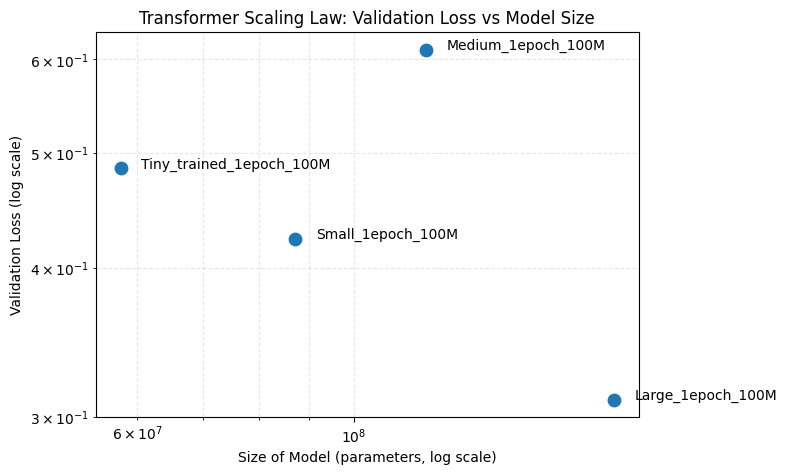

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model_name  = [m["name"] for m in models]
params = np.array([m["params"] for m in models], dtype=float)
losses = np.array([m["val_loss"] for m in models], dtype=float)

plt.figure(figsize=(7,5))
plt.scatter(params, losses, s=80)

for x,n in enumerate(model_name):
    plt.text(params[x]*1.05, losses[x], n, fontsize=10)

plt.yscale("log")
plt.xscale("log")

plt.ylabel("Validation Loss (log scale)")
plt.xlabel("Size of Model (parameters, log scale)")
plt.title("Transformer Scaling Law: Validation Loss vs Model Size")

plt.grid(True, which="both", ls="--", alpha=0.3)
plt.show()


In [ ]:
logN = np.log(params)
logL = np.log(losses)

A = np.vstack([logN, np.ones(len(logN))]).T
alpha_neg, logk = np.linalg.lstsq(A, logL, rcond=None)[0]

alpha = -alpha_neg
k = np.exp(logk)
print("Estimated scaling exponent α:", alpha)
print("Constant k:", k)


Estimated scaling exponent α: 0.288336104032268
Constant k: 90.67014509285835


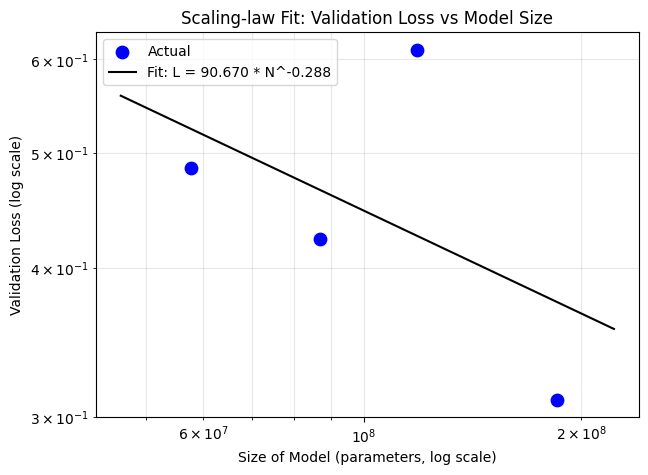

In [ ]:
N_smooth = np.logspace(np.log10(min(params)*0.8),
                       np.log10(max(params)*1.2), 200)

pred = k * (N_smooth**(-alpha))

plt.figure(figsize=(7,5))
plt.scatter(params, losses, color='blue', s=80, label='Actual')
plt.plot(N_smooth, pred, 'k', label=f"Fit: L = {k:.3f} * N^-{alpha:.3f}")

plt.xscale("log"); plt.yscale("log")
plt.xlabel("Size of Model (parameters, log scale)")
plt.ylabel("Validation Loss (log scale)")
plt.title("Scaling-law Fit: Validation Loss vs Model Size")
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.legend()
plt.show()


This is our scaling law fit for models, although, medium sized model seems to be an outlier, but rest other models appears to be a linear fit.

### Part 3 - Using LSTM

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/ml-project-dataset/dataset_ready.zip" -d /content/dataset_ready


Archive:  /content/drive/MyDrive/ml-project-dataset/dataset_ready.zip
  inflating: /content/dataset_ready/train.bin  
  inflating: /content/dataset_ready/val.bin  
  inflating: /content/dataset_ready/test.bin  
  inflating: /content/dataset_ready/vocab.json  


In [5]:
import numpy as np

train_path = "/content/dataset_ready/train.bin"
test_path  = "/content/dataset_ready/test.bin"
val_path   = "/content/dataset_ready/val.bin"

train_tokens = np.memmap(train_path, dtype=np.uint16, mode="r")
val_tokens   = np.memmap(val_path, dtype=np.uint16, mode="r")
test_tokens  = np.memmap(test_path, dtype=np.uint16, mode="r")


In [11]:
import pickle

meta_path = "/content/dataset_ready/meta.pkl"
with open(meta_path, "rb") as f:
    meta = pickle.load(f)

vocab_size = meta["vocab_size"]
dtype = meta.get("dtype", "uint16")
print("Loaded from meta.pkl:")
print(" vocab_size =", vocab_size)
print(" dtype      =", dtype)


Loaded from meta.pkl:
 vocab_size = 222065
 dtype      = uint16


In [12]:
train_tokens = np.memmap("/content/dataset_ready/train.bin", dtype=dtype, mode="r")
val_tokens   = np.memmap("/content/dataset_ready/val.bin",   dtype=dtype, mode="r")


In [13]:
from torch.utils.data import IterableDataset
class TokenStream(IterableDataset):
    def __init__(self, tokens, seq_len):
        self.tokens = tokens
        self.seq_len = seq_len
        self.n = len(tokens)

    def __iter__(self):
        import random
        while True:
            i = random.randint(0, self.n - self.seq_len - 2)
            seq = self.tokens[i:i+self.seq_len+1]
            yield torch.tensor(seq, dtype=torch.long)


In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, IterableDataset
from torch import amp
import numpy as np

device = "cuda"
import json

with open("/content/dataset_ready/vocab.json") as f:
    data = json.load(f)

vocab_list = data["vocab"]
vocab_size = len(vocab_list)

seq_len = 512
batch_size = 8

train_loader = DataLoader(
    TokenStream(train_tokens, seq_len),
    batch_size=batch_size,
    pin_memory=True,
)

val_loader = DataLoader(
    TokenStream(val_tokens, seq_len),
    batch_size=batch_size,
    pin_memory=True,
)
train_iter = iter(train_loader)
val_iter   = iter(val_loader)



In [16]:
import torch
import torch.nn as nn

class LSTMLM(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers,
                 tie_embeddings=True, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.proj_in = nn.Linear(emb_dim, hidden_dim, bias=False) \
                       if emb_dim != hidden_dim else None

        self.lstm = nn.LSTM(hidden_dim, hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout if num_layers > 1 else 0)
        self.output = nn.Linear(hidden_dim, vocab_size, bias=False)
        if tie_embeddings and emb_dim == hidden_dim:
            self.output.weight = self.embedding.weight

    def forward(self, tokens, hidden=None):
        x = self.embedding(tokens)
        if self.proj_in is not None:
            x = self.proj_in(x)
        out, hidden = self.lstm(x, hidden)
        logits = self.output(out)
        return logits, hidden


def count_params(model):
    return sum(p.numel() for p in model.parameters())


Now, as we have created our model, the next step is to train them, So, in different blocks, I would be training my model using different configurationns such as LSTM-57M, LSTM-87M, LSTM-118M, LSTM-184M

In [22]:
import torch
from torch import amp
import csv, time, os
from math import floor

device = "cuda"

batch_size = 8
grad_accum = 4
seq_len = 512
max_tokens = 10_000_000
validate_every = 2_000_000
eval_batches = 50

configs = {
    "LSTM_57M":  dict(emb=256,  hidden=1536, layers=3),
    "LSTM_87M":  dict(emb=1536, hidden=1536, layers=2),
}

os.makedirs("checkpoints_lstm", exist_ok=True)
os.makedirs("logs_lstm", exist_ok=True)

csv_path = "logs_lstm/lstm_results.csv"
with open(csv_path, "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["model_name", "params", "final_val_loss"])

results = []

for model_name, cfg in configs.items():

    print("\n=====================================================")
    print(f"TRAINING MODEL: {model_name}")
    print("=====================================================\n")
    model = LSTMLM(vocab_size, cfg["emb"], cfg["hidden"], cfg["layers"]).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
    criterion = nn.CrossEntropyLoss()
    scaler = amp.GradScaler()

    params = sum(p.numel() for p in model.parameters())
    print(f"Params: {params:,}")
    train_iter = iter(train_loader)
    val_iter = iter(val_loader)
    tokens_seen = 0
    accum = 0
    model.train()

    start_time = time.time()
    last_log_time = start_time
    last_tokens = 0

    while tokens_seen < max_tokens:
        batch = next(train_iter).to(device)
        inp  = batch[:, :-1]
        targ = batch[:, 1:]

        with amp.autocast("cuda"):
            logits, _ = model(inp)
            loss = criterion(logits.reshape(-1, vocab_size), targ.reshape(-1))

        scaler.scale(loss).backward()
        accum += 1

        if accum == grad_accum:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            accum = 0
        tokens_seen += inp.numel()
        now = time.time()
        if now - last_log_time >= 1.0:
            dt = now - last_log_time
            tps = (tokens_seen - last_tokens) / dt
            pct = (tokens_seen / max_tokens) * 100

            eta = (max_tokens - tokens_seen) / max(tps, 1e-9)
            eta_min = eta / 60

            print(
                f"[{model_name}] {pct:5.1f}% | "
                f"{tokens_seen:,} tokens | "
                f"loss={loss.item():.4f} | "
                f"{tps:,.0f} tok/s | "
                f"ETA={eta_min:5.1f} min"
            )

            last_log_time = now
            last_tokens = tokens_seen
        if tokens_seen % validate_every < inp.numel():

            print(f"\n>>> Running Validation at {tokens_seen:,} tokens...")
            model.eval()
            val_loss = 0.0
            val_start = time.time()

            with torch.no_grad():
                for _ in range(eval_batches):

                    try:
                        vb = next(val_iter)
                    except StopIteration:
                        val_iter = iter(val_loader)
                        vb = next(val_iter)

                    vb = vb.to(device)
                    vi = vb[:, :-1]
                    vt = vb[:, 1:]

                    with amp.autocast("cuda"):
                        vlogits, _ = model(vi)
                        vloss = criterion(
                            vlogits.reshape(-1, vocab_size),
                            vt.reshape(-1)
                        )

                    val_loss += vloss.item()

            val_loss /= eval_batches
            print(f"[VAL] {model_name} | tokens={tokens_seen:,}, val_loss={val_loss:.4f}")
            print(f"Validation took {time.time() - val_start:.2f} sec\n")

            model.train()

    ckpt_path = f"checkpoints_lstm/{model_name}.pt"
    torch.save({"model": model.state_dict(), "cfg": cfg, "vocab_size": vocab_size}, ckpt_path)

    print(f"Saved checkpoint -> {ckpt_path}")

    with open(csv_path, "a", newline='') as f:
        writer = csv.writer(f)
        writer.writerow([model_name, params, val_loss])

    elapsed = (time.time() - start_time) / 60
    print(f"Finished {model_name}: val_loss={val_loss:.4f}, time={elapsed:.2f} min")

    results.append((model_name, params, val_loss))


print("\n==============================")
print("ALL MODELS TRAINED — FINAL RESULTS")
print("==============================")
for r in results:
    print(r)



TRAINING MODEL: LSTM_57M

Params: 454,993,664
[LSTM_57M]   0.2% | 16,384 tokens | loss=12.3113 | 12,974 tok/s | ETA= 12.8 min
[LSTM_57M]   0.3% | 32,768 tokens | loss=12.2063 | 13,961 tok/s | ETA= 11.9 min
[LSTM_57M]   0.5% | 49,152 tokens | loss=11.8390 | 13,916 tok/s | ETA= 11.9 min
[LSTM_57M]   0.7% | 65,536 tokens | loss=9.7963 | 13,962 tok/s | ETA= 11.9 min
[LSTM_57M]   0.8% | 81,920 tokens | loss=8.0460 | 13,906 tok/s | ETA= 11.9 min
[LSTM_57M]   1.0% | 98,304 tokens | loss=6.6750 | 13,955 tok/s | ETA= 11.8 min
[LSTM_57M]   1.1% | 114,688 tokens | loss=5.4942 | 13,902 tok/s | ETA= 11.9 min
[LSTM_57M]   1.3% | 131,072 tokens | loss=4.9034 | 13,789 tok/s | ETA= 11.9 min
[LSTM_57M]   1.5% | 147,456 tokens | loss=4.7181 | 13,955 tok/s | ETA= 11.8 min
[LSTM_57M]   1.6% | 163,840 tokens | loss=4.3396 | 13,932 tok/s | ETA= 11.8 min
[LSTM_57M]   1.8% | 180,224 tokens | loss=4.1814 | 13,976 tok/s | ETA= 11.7 min
[LSTM_57M]   2.0% | 196,608 tokens | loss=3.4732 | 13,972 tok/s | ETA= 11.7 

In [21]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
from torch import amp
import csv, time, os
from math import floor


device = "cuda"
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

batch_size = 8
grad_accum = 4

grad_accum = 4
seq_len = 512
max_tokens = 10_000_000
validate_every = 2_000_000
eval_batches = 50

configs = {
    "LSTM_118M": dict(emb=3584, hidden=256,  layers=2),
}

os.makedirs("checkpoints_lstm", exist_ok=True)
os.makedirs("logs_lstm", exist_ok=True)

csv_path = "logs_lstm/lstm_results.csv"
with open(csv_path, "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["model_name", "params", "final_val_loss"])

results = []

for model_name, cfg in configs.items():

    print("\n=====================================================")
    print(f"TRAINING MODEL: {model_name}")
    print("=====================================================\n")
    model = LSTMLM(vocab_size, cfg["emb"], cfg["hidden"], cfg["layers"]).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
    criterion = nn.CrossEntropyLoss()
    scaler = amp.GradScaler()

    params = sum(p.numel() for p in model.parameters())
    print(f"Params: {params:,}")
    train_iter = iter(train_loader)
    val_iter = iter(val_loader)
    tokens_seen = 0
    accum = 0
    model.train()

    start_time = time.time()
    last_log_time = start_time
    last_tokens = 0

    while tokens_seen < max_tokens:
        batch = next(train_iter).to(device)
        inp  = batch[:, :-1]
        targ = batch[:, 1:]

        with amp.autocast("cuda"):
            logits, _ = model(inp)
            loss = criterion(logits.reshape(-1, vocab_size), targ.reshape(-1))

        scaler.scale(loss).backward()
        accum += 1

        if accum == grad_accum:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            accum = 0
        tokens_seen += inp.numel()
        now = time.time()
        if now - last_log_time >= 1.0:
            dt = now - last_log_time
            tps = (tokens_seen - last_tokens) / dt
            pct = (tokens_seen / max_tokens) * 100

            eta = (max_tokens - tokens_seen) / max(tps, 1e-9)
            eta_min = eta / 60

            print(
                f"[{model_name}] {pct:5.1f}% | "
                f"{tokens_seen:,} tokens | "
                f"loss={loss.item():.4f} | "
                f"{tps:,.0f} tok/s | "
                f"ETA={eta_min:5.1f} min"
            )

            last_log_time = now
            last_tokens = tokens_seen
        if tokens_seen % validate_every < inp.numel():

            print(f"\n>>> Running Validation at {tokens_seen:,} tokens...")
            model.eval()
            val_loss = 0.0
            val_start = time.time()

            with torch.no_grad():
                for _ in range(eval_batches):

                    try:
                        vb = next(val_iter)
                    except StopIteration:
                        val_iter = iter(val_loader)
                        vb = next(val_iter)

                    vb = vb.to(device)
                    vi = vb[:, :-1]
                    vt = vb[:, 1:]

                    with amp.autocast("cuda"):
                        vlogits, _ = model(vi)
                        vloss = criterion(
                            vlogits.reshape(-1, vocab_size),
                            vt.reshape(-1)
                        )

                    val_loss += vloss.item()

            val_loss /= eval_batches
            print(f"[VAL] {model_name} | tokens={tokens_seen:,}, val_loss={val_loss:.4f}")
            print(f"Validation took {time.time() - val_start:.2f} sec\n")

            model.train()

    ckpt_path = f"checkpoints_lstm/{model_name}.pt"
    torch.save({"model": model.state_dict(), "cfg": cfg, "vocab_size": vocab_size}, ckpt_path)

    print(f"Saved checkpoint -> {ckpt_path}")

    with open(csv_path, "a", newline='') as f:
        writer = csv.writer(f)
        writer.writerow([model_name, params, val_loss])

    elapsed = (time.time() - start_time) / 60
    print(f"Finished {model_name}: val_loss={val_loss:.4f}, time={elapsed:.2f} min")

    results.append((model_name, params, val_loss))


print("\n==============================")
print("ALL MODELS TRAINED — FINAL RESULTS")
print("==============================")
for r in results:
    print(r)



TRAINING MODEL: LSTM_118M

Params: 854,699,776
[LSTM_118M]   0.3% | 32,768 tokens | loss=12.2346 | 29,589 tok/s | ETA=  5.6 min
[LSTM_118M]   0.7% | 65,536 tokens | loss=12.0901 | 30,246 tok/s | ETA=  5.5 min
[LSTM_118M]   1.0% | 98,304 tokens | loss=11.8773 | 30,415 tok/s | ETA=  5.4 min
[LSTM_118M]   1.3% | 131,072 tokens | loss=11.6145 | 30,492 tok/s | ETA=  5.4 min
[LSTM_118M]   1.6% | 163,840 tokens | loss=11.1785 | 30,452 tok/s | ETA=  5.4 min
[LSTM_118M]   2.0% | 196,608 tokens | loss=10.7773 | 30,508 tok/s | ETA=  5.4 min
[LSTM_118M]   2.3% | 229,376 tokens | loss=10.3218 | 30,338 tok/s | ETA=  5.4 min
[LSTM_118M]   2.6% | 262,144 tokens | loss=9.9088 | 30,431 tok/s | ETA=  5.3 min
[LSTM_118M]   2.9% | 294,912 tokens | loss=9.4020 | 30,199 tok/s | ETA=  5.4 min
[LSTM_118M]   3.3% | 327,680 tokens | loss=9.0781 | 30,287 tok/s | ETA=  5.3 min
[LSTM_118M]   3.6% | 360,448 tokens | loss=8.5762 | 30,301 tok/s | ETA=  5.3 min
[LSTM_118M]   3.9% | 393,216 tokens | loss=8.2550 | 30,38

In [19]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
from torch import amp
import csv, time, os
from math import floor


device = "cuda"
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

batch_size = 8
grad_accum = 4

grad_accum = 4
seq_len = 512
max_tokens = 10_000_000
validate_every = 2_000_000
eval_batches = 50

configs = {
    "LSTM_184M": dict(emb=3584, hidden=1536, layers=3),
}

os.makedirs("checkpoints_lstm", exist_ok=True)
os.makedirs("logs_lstm", exist_ok=True)

csv_path = "logs_lstm/lstm_results.csv"
with open(csv_path, "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["model_name", "params", "final_val_loss"])

results = []

for model_name, cfg in configs.items():

    print("\n=====================================================")
    print(f"TRAINING MODEL: {model_name}")
    print("=====================================================\n")
    model = LSTMLM(vocab_size, cfg["emb"], cfg["hidden"], cfg["layers"]).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
    criterion = nn.CrossEntropyLoss()
    scaler = amp.GradScaler()

    params = sum(p.numel() for p in model.parameters())
    print(f"Params: {params:,}")
    train_iter = iter(train_loader)
    val_iter = iter(val_loader)
    tokens_seen = 0
    accum = 0
    model.train()

    start_time = time.time()
    last_log_time = start_time
    last_tokens = 0

    while tokens_seen < max_tokens:
        batch = next(train_iter).to(device)
        inp  = batch[:, :-1]
        targ = batch[:, 1:]

        with amp.autocast("cuda"):
            logits, _ = model(inp)
            loss = criterion(logits.reshape(-1, vocab_size), targ.reshape(-1))

        scaler.scale(loss).backward()
        accum += 1

        if accum == grad_accum:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            accum = 0
        tokens_seen += inp.numel()
        now = time.time()
        if now - last_log_time >= 1.0:
            dt = now - last_log_time
            tps = (tokens_seen - last_tokens) / dt
            pct = (tokens_seen / max_tokens) * 100

            eta = (max_tokens - tokens_seen) / max(tps, 1e-9)
            eta_min = eta / 60

            print(
                f"[{model_name}] {pct:5.1f}% | "
                f"{tokens_seen:,} tokens | "
                f"loss={loss.item():.4f} | "
                f"{tps:,.0f} tok/s | "
                f"ETA={eta_min:5.1f} min"
            )

            last_log_time = now
            last_tokens = tokens_seen
        if tokens_seen % validate_every < inp.numel():

            print(f"\n>>> Running Validation at {tokens_seen:,} tokens...")
            model.eval()
            val_loss = 0.0
            val_start = time.time()

            with torch.no_grad():
                for _ in range(eval_batches):

                    try:
                        vb = next(val_iter)
                    except StopIteration:
                        val_iter = iter(val_loader)
                        vb = next(val_iter)

                    vb = vb.to(device)
                    vi = vb[:, :-1]
                    vt = vb[:, 1:]

                    with amp.autocast("cuda"):
                        vlogits, _ = model(vi)
                        vloss = criterion(
                            vlogits.reshape(-1, vocab_size),
                            vt.reshape(-1)
                        )

                    val_loss += vloss.item()

            val_loss /= eval_batches
            print(f"[VAL] {model_name} | tokens={tokens_seen:,}, val_loss={val_loss:.4f}")
            print(f"Validation took {time.time() - val_start:.2f} sec\n")

            model.train()

    ckpt_path = f"checkpoints_lstm/{model_name}.pt"
    torch.save({"model": model.state_dict(), "cfg": cfg, "vocab_size": vocab_size}, ckpt_path)

    print(f"Saved checkpoint -> {ckpt_path}")

    with open(csv_path, "a", newline='') as f:
        writer = csv.writer(f)
        writer.writerow([model_name, params, val_loss])

    elapsed = (time.time() - start_time) / 60
    print(f"Finished {model_name}: val_loss={val_loss:.4f}, time={elapsed:.2f} min")

    results.append((model_name, params, val_loss))


print("\n==============================")
print("ALL MODELS TRAINED — FINAL RESULTS")
print("==============================")
for r in results:
    print(r)



TRAINING MODEL: LSTM_184M

Params: 1,199,137,792
[LSTM_184M]   0.1% | 12,288 tokens | loss=12.3113 | 9,811 tok/s | ETA= 17.0 min
[LSTM_184M]   0.2% | 24,576 tokens | loss=12.1921 | 9,826 tok/s | ETA= 16.9 min
[LSTM_184M]   0.4% | 40,960 tokens | loss=11.6086 | 13,105 tok/s | ETA= 12.7 min
[LSTM_184M]   0.6% | 57,344 tokens | loss=9.6642 | 13,098 tok/s | ETA= 12.7 min
[LSTM_184M]   0.7% | 73,728 tokens | loss=7.8156 | 13,062 tok/s | ETA= 12.7 min
[LSTM_184M]   0.9% | 90,112 tokens | loss=6.7863 | 13,127 tok/s | ETA= 12.6 min
[LSTM_184M]   1.1% | 106,496 tokens | loss=5.6883 | 13,140 tok/s | ETA= 12.5 min
[LSTM_184M]   1.2% | 122,880 tokens | loss=5.1487 | 13,142 tok/s | ETA= 12.5 min
[LSTM_184M]   1.4% | 139,264 tokens | loss=4.6954 | 13,164 tok/s | ETA= 12.5 min
[LSTM_184M]   1.6% | 155,648 tokens | loss=4.3250 | 13,103 tok/s | ETA= 12.5 min
[LSTM_184M]   1.7% | 172,032 tokens | loss=4.2579 | 13,140 tok/s | ETA= 12.5 min
[LSTM_184M]   1.9% | 188,416 tokens | loss=3.8989 | 13,119 tok/s

In [ ]:
ckpt = torch.load("checkpoints_lstm/LSTM_184M.pt", map_location="cpu")
model = LSTMLM(ckpt["vocab_size"], cfg["emb"], cfg["hidden"], cfg["layers"])
model.load_state_dict(ckpt["model"])
model.eval()


LSTMLM(
  (embedding): Embedding(222065, 3584)
  (proj_in): Linear(in_features=3584, out_features=1536, bias=False)
  (lstm): LSTM(1536, 1536, num_layers=3, batch_first=True, dropout=0.1)
  (output): Linear(in_features=1536, out_features=222065, bias=False)
)

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import csv
class LSTMLM(nn.Module):
    def __init__(self, vocab_size, emb, hidden, layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb)
        self.proj_in = nn.Linear(emb, hidden, bias=False)
        self.lstm = nn.LSTM(hidden, hidden, num_layers=layers, batch_first=True, dropout=0.1)
        self.output = nn.Linear(hidden, vocab_size, bias=False)

    def forward(self, x, state=None):
        x = self.embedding(x)
        x = self.proj_in(x)
        out, state = self.lstm(x, state)
        logits = self.output(out)
        return logits, state

checkpoints = [
    ("LSTM_57M",  "checkpoints_lstm/LSTM_57M.pt"),
    ("LSTM_87M",  "checkpoints_lstm/LSTM_87M.pt"),
    ("LSTM_118M", "checkpoints_lstm/LSTM_118M.pt"),
    ("LSTM_184M", "checkpoints_lstm/LSTM_184M.pt"),
]

val_iter = iter(val_loader)

device = "cuda"
eval_batches = 500

criterion = nn.CrossEntropyLoss()

results = []
for name, path in checkpoints:

    print(f"\n=== Evaluating {name} ===")

    ckpt = torch.load(path, map_location=device)
    cfg = ckpt["cfg"]
    vocab = ckpt["vocab_size"]

    model = LSTMLM(vocab, cfg["emb"], cfg["hidden"], cfg["layers"]).to(device)
    model.load_state_dict(ckpt["model"], strict=False)
    model.eval()

    total_loss = 0
    tok_count = 0

    with torch.no_grad():
        for _ in range(eval_batches):

            try:
                batch = next(val_iter)
            except StopIteration:
                val_iter = iter(val_loader)
                batch = next(val_iter)

            batch = batch.to(device)
            inp = batch[:, :-1]
            targ = batch[:, 1:]

            logits, _ = model(inp)
            loss = criterion(
                logits.reshape(-1, vocab),
                targ.reshape(-1)
            )

            total_loss += loss.item()

    avg_loss = total_loss / eval_batches
    ppl = torch.exp(torch.tensor(avg_loss)).item()

    print(f"{name}: loss={avg_loss:.4f}, ppl={ppl:.2f}")

    results.append((name, avg_loss, ppl))
with open("lstm_eval_results.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["model_name", "val_loss", "perplexity"])
    writer.writerows(results)

print("\nSaved -> lstm_eval_results.csv")
print("\nDONE.")



=== Evaluating LSTM_57M ===
LSTM_57M: loss=1.6675, ppl=5.30

=== Evaluating LSTM_87M ===
LSTM_87M: loss=1.0027, ppl=2.73

=== Evaluating LSTM_118M ===
LSTM_118M: loss=1.1339, ppl=3.11

=== Evaluating LSTM_184M ===
LSTM_184M: loss=1.2199, ppl=3.39

Saved -> lstm_eval_results.csv

DONE.


The LSTM training appers to be be converging around models having 87M parameters and then again the validation loss is increasing

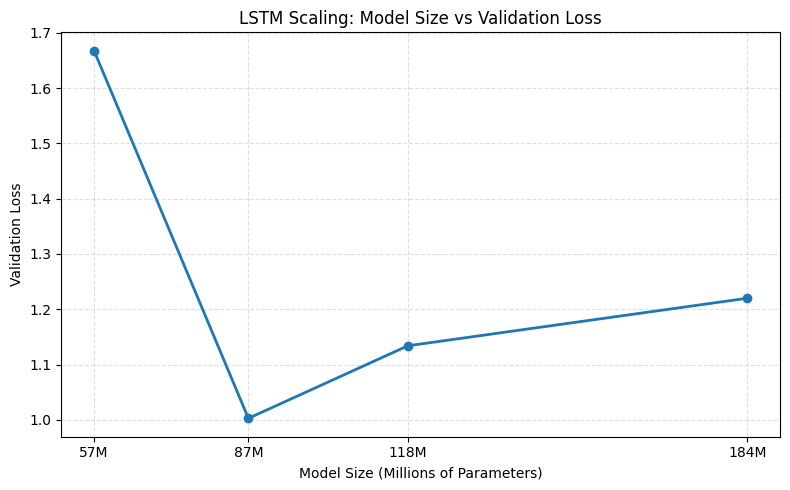

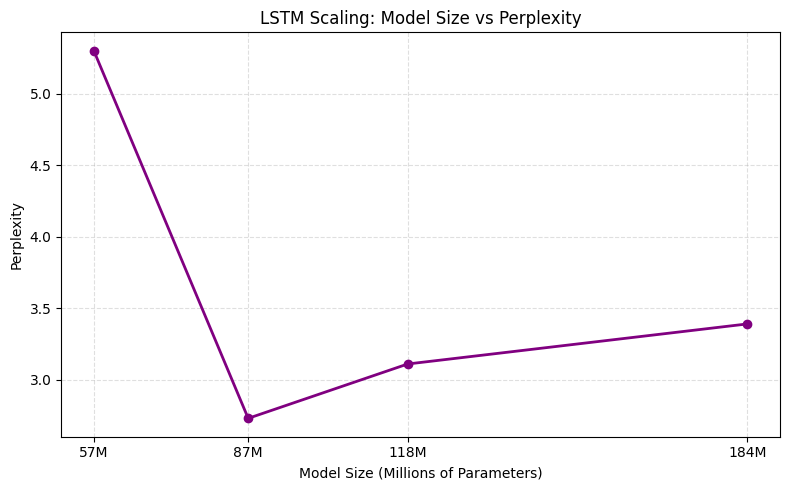

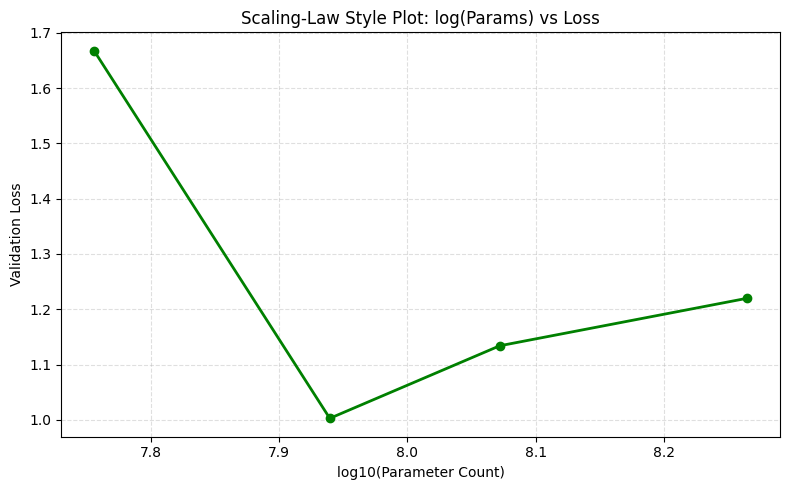

In [24]:
import matplotlib.pyplot as plt
import numpy as np
model_names = ["LSTM_57M", "LSTM_87M", "LSTM_118M", "LSTM_184M"]
params = np.array([57e6, 87e6, 118e6, 184e6])   # parameter counts
losses = np.array([1.6675, 1.0027, 1.1339, 1.2199])
ppls = np.array([5.30, 2.73, 3.11, 3.39])
param_labels = ["57M", "87M", "118M", "184M"]
plt.figure(figsize=(8,5))
plt.plot(params/1e6, losses, marker='o', linewidth=2)
plt.xticks(params/1e6, param_labels)
plt.xlabel("Model Size (Millions of Parameters)")
plt.ylabel("Validation Loss")
plt.title("LSTM Scaling: Model Size vs Validation Loss")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
plt.figure(figsize=(8,5))
plt.plot(params/1e6, ppls, marker='o', color='purple', linewidth=2)
plt.xticks(params/1e6, param_labels)
plt.xlabel("Model Size (Millions of Parameters)")
plt.ylabel("Perplexity")
plt.title("LSTM Scaling: Model Size vs Perplexity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
plt.figure(figsize=(8,5))
plt.plot(np.log10(params), losses, marker='o', color='green', linewidth=2)
plt.xlabel("log10(Parameter Count)")
plt.ylabel("Validation Loss")
plt.title("Scaling-Law Style Plot: log(Params) vs Loss")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


THe same can be verified using the scaling law plots given above. Now, I am plotting the comparison for Transformer and LSTM models.

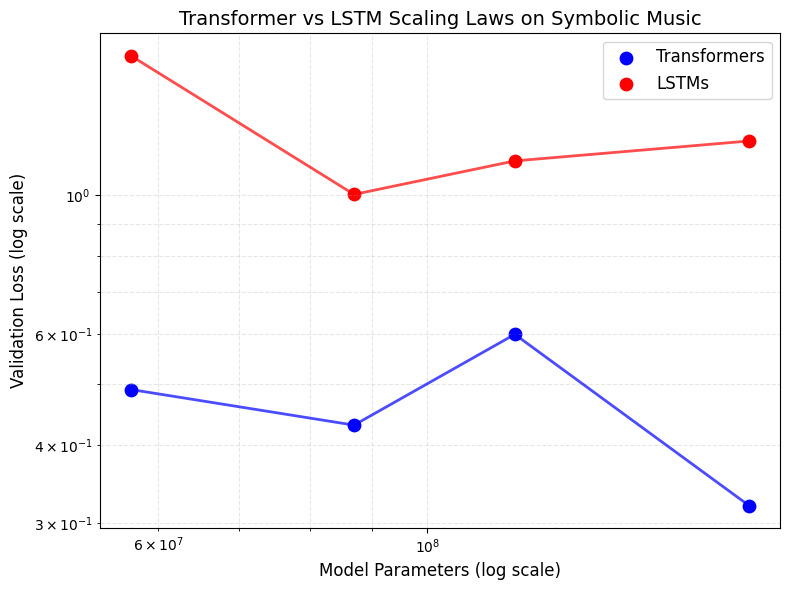

In [35]:
import matplotlib.pyplot as plt
import numpy as np
tf_names = ["Tiny", "Small", "Medium", "Large"]
tf_params = np.array([57e6, 87e6, 118e6, 184e6])
tf_losses = np.array([0.49, 0.43, 0.60, 0.32])
lstm_names = ["LSTM_57M", "LSTM_87M", "LSTM_118M", "LSTM_184M"]
lstm_params = np.array([57e6, 87e6, 118e6, 184e6])
lstm_losses = np.array([1.6675, 1.0027, 1.1339, 1.2199])
plt.figure(figsize=(8,6))
plt.scatter(tf_params, tf_losses, color="blue", label="Transformers", s=80)
plt.plot(tf_params, tf_losses, color="blue", linewidth=2, alpha=0.7)
plt.scatter(lstm_params, lstm_losses, color="red", label="LSTMs", s=80)
plt.plot(lstm_params, lstm_losses, color="red", linewidth=2, alpha=0.7)
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Model Parameters (log scale)", fontsize=12)
plt.ylabel("Validation Loss (log scale)", fontsize=12)
plt.title("Transformer vs LSTM Scaling Laws on Symbolic Music", fontsize=14)

plt.grid(True, which="both", linestyle="--", alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


The transformers perfomed much better on our dataset, and as we are increasing the model parameters in transformer, it apprears to converge.

In [33]:
ckpt = torch.load("/content/checkpoints_lstm/Tiny_trained_1epoch_100M.pt", map_location="cpu")
print(ckpt.keys())


dict_keys(['cfg', 'total_params', 'avg_train_loss', 'val_loss'])


### Part 4 a - Training Largest Model

In [36]:
model = GPT(
    vocab_size=vocab_size,
    block_size=256,
    n_layer=8,
    n_head=8,
    n_embd=512
).cuda()


In [57]:
import torch, time, os
from torch.cuda.amp import GradScaler, autocast
from torch.optim import AdamW

large_personalized_model_cfg = {
    "name": "Large",
    "n_layer": 8,
    "n_head": 8,
    "n_embd": 384,
    "block_size": 256
}

SAVE_PATH = "/content/large_model_trained.pt"

model = GPT(
    vocab_size=vocab_size,
    block_size=large_personalized_model_cfg["block_size"],
    n_layer=large_personalized_model_cfg["n_layer"],
    n_head=large_personalized_model_cfg["n_head"],
    n_embd=large_personalized_model_cfg["n_embd"]
).cuda()

total_params = sum(p.numel() for p in model.parameters())
print(f"Large model params: {total_params:,} ({total_params/1e6:.3f}M)")

total_tokens_to_train = 200_000_000
batch_size = 4
block_size = large_personalized_model_cfg["block_size"]
lr = 3e-4
weight_decay = 0.1
grad_clip = 1.0

tokens_per_step = batch_size * block_size
max_steps = total_tokens_to_train // tokens_per_step

optimizer = AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=weight_decay)
scaler = GradScaler()

print(f"Training Large model for {total_tokens_to_train:,} tokens ({max_steps} steps)...")

model.train()
start_time = time.time()
log_every = max(1, max_steps // 100)

for step in range(1, max_steps + 1):
    x, y = get_batch("train", batch_size=batch_size, block_size=block_size)
    with autocast():
        logits, loss = model(x, y)

    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.unscale_(optimizer)
    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    scaler.step(optimizer)
    scaler.update()

    if step % log_every == 0 or step == 1:
        elapsed = time.time() - start_time
        progress = step / max_steps
        remaining = elapsed / progress - elapsed
        tok_sec = (step * tokens_per_step) / max(1, elapsed)
        print(
            f"[Step {step:6d}/{max_steps}] "
            f"{progress*100:5.1f}% | "
            f"loss={loss.item():.4f} | "
            f"{tok_sec:,.0f} tok/s | "
            f"elapsed={elapsed/60:5.1f}m | "
            f"ETA={remaining/60:5.1f}m"
        )

checkpoint = {
    "model": model.state_dict(),
    "cfg": large_personalized_model_cfg,
    "vocab_size": vocab_size
}

torch.save(checkpoint, SAVE_PATH)
print(f"\nSaved trained Large model -> {SAVE_PATH}")


Large model params: 184,840,704 (184.841M)
Training Large model for 200,000,000 tokens (195312 steps)...
[Step      1/195312]   0.0% | loss=12.4327 | 1,024 tok/s | elapsed=  0.0m | ETA=238.8m


/tmp/ipython-input-671765956.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-671765956.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Step   1953/195312]   1.0% | loss=0.5980 | 16,788 tok/s | elapsed=  2.0m | ETA=196.6m
[Step   3906/195312]   2.0% | loss=0.2217 | 16,781 tok/s | elapsed=  4.0m | ETA=194.7m
[Step   5859/195312]   3.0% | loss=0.6397 | 16,738 tok/s | elapsed=  6.0m | ETA=193.2m
[Step   7812/195312]   4.0% | loss=0.0274 | 16,728 tok/s | elapsed=  8.0m | ETA=191.3m
[Step   9765/195312]   5.0% | loss=0.4018 | 16,700 tok/s | elapsed= 10.0m | ETA=189.6m
[Step  11718/195312]   6.0% | loss=0.1400 | 16,715 tok/s | elapsed= 12.0m | ETA=187.5m
[Step  13671/195312]   7.0% | loss=0.2429 | 16,728 tok/s | elapsed= 13.9m | ETA=185.3m
[Step  15624/195312]   8.0% | loss=0.2993 | 16,740 tok/s | elapsed= 15.9m | ETA=183.2m
[Step  17577/195312]   9.0% | loss=0.3169 | 16,747 tok/s | elapsed= 17.9m | ETA=181.1m
[Step  19530/195312]  10.0% | loss=0.3450 | 16,755 tok/s | elapsed= 19.9m | ETA=179.1m
[Step  21483/195312]  11.0% | loss=0.1807 | 16,759 tok/s | elapsed= 21.9m | ETA=177.0m
[Step  23436/195312]  12.0% | loss=0.4003 |

Here I trained my largest possible model given my computation units left in the colab. 

In [58]:
import math

ckpt = torch.load("/content/large_model_trained.pt", map_location="cuda")
cfg = ckpt["cfg"]

model = GPT(
    vocab_size=vocab_size,
    block_size=cfg["block_size"],
    n_layer=cfg["n_layer"],
    n_head=cfg["n_head"],
    n_embd=cfg["n_embd"]
).cuda()

model.load_state_dict(ckpt["model"])
model.eval()
with torch.no_grad():
    x, y = get_batch("val", batch_size=4, block_size=cfg["block_size"])
    logits, val_loss = model(x, y)

print("Validation Loss:", val_loss.item())
print("Validation Perplexity:", math.exp(val_loss.item()))


Validation Loss: 0.44480374455451965
Validation Perplexity: 1.5601839711842262


I am seeing the validation loss of 0.44 and validation perplexity of 1.56. This could be reduced by training a larger model

I stored the model file in my local as my compute units are over, and will show the predictions there.